# 0.0 Imports

In [1]:
import pickle

import pandas     as pd
import numpy      as np
import seaborn    as sns
import boruta     as bt
import scikitplot as skplt

from IPython.display       import Image
from IPython.core.display  import HTML

from matplotlib            import pyplot          as plt
from sklearn               import preprocessing   as pp
from sklearn               import linear_model    as lm
from sklearn               import model_selection as ms
from sklearn               import ensemble        as en
from sklearn               import neighbors       as nh
from sklearn.metrics       import accuracy_score

import warnings

warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [40]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [3]:
# import data

df_raw = pd.read_csv('../data/raw/train.csv')
df_raw.head(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
df_raw.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [5]:
columns_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response']

df_raw.columns = columns_new
df_raw.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

In [6]:
df1 = df_raw

# 1.0 Data Description

## 1.1 Data Dimension

In [7]:
print('Total of rows: {}' .format(df1.shape[0]))
print('Total of columns: {}' .format(df1.shape[1]))

Total of rows: 381109
Total of columns: 12


## 1.2. Data Types

In [8]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3. Check NA 

In [9]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4. Data Descriptive

In [10]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])

In [11]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


In [10]:
df2 = df1

## 2.0. Feature Engineering

In [11]:
df2.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

In [12]:
df2['vehicle_age'].unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

In [13]:
df2['vehicle_damage'].unique()

array(['Yes', 'No'], dtype=object)

In [14]:
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: '<1_year' if x== '< 1 Year' else '1-2_year' if x == '1-2 Year' else '>2_years')
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

In [15]:
df3 = df2

# 3.0 Data Filtering 

In [16]:
df4 = df3

# 4.0 EDA 

## 4.1 Univariate Analysis

In [17]:
df4.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage            int64
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

### 4.1.1. Age

<AxesSubplot:xlabel='response', ylabel='age'>

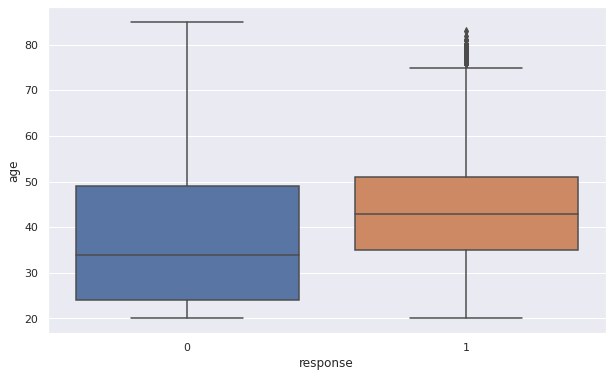

In [20]:
# Age
plt.figure(figsize = (10,6))
sns.boxplot(y = 'age', x = 'response', data = df4)

<AxesSubplot:xlabel='age', ylabel='Count'>

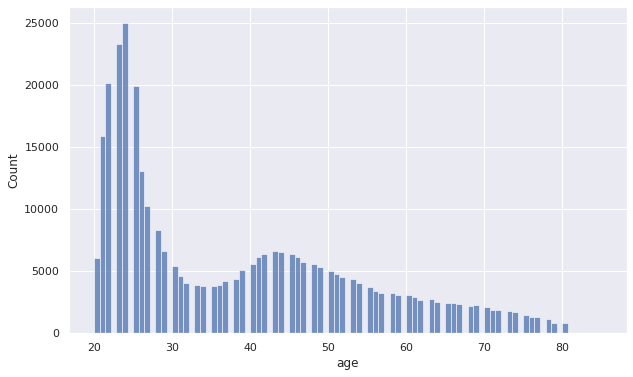

In [21]:
plt.figure(figsize(10,6))
aux0 = df4.loc[df4['response']  == 0, 'age']
sns.histplot(aux0)

<AxesSubplot:xlabel='age', ylabel='Count'>

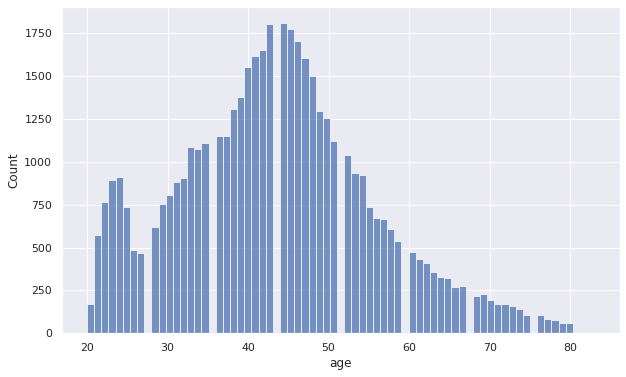

In [130]:
plt.figure(figsize(10,6))
aux0 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux0)

### 4.1.2. Annual Income

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

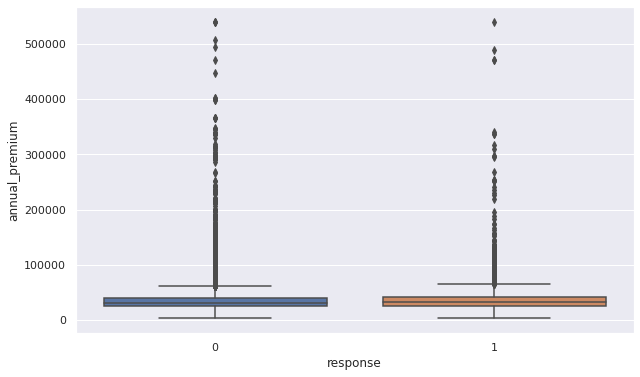

In [42]:
plt.figure(figsize(10,6))
sns.boxplot(x = 'response', y = 'annual_premium', data = df4)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

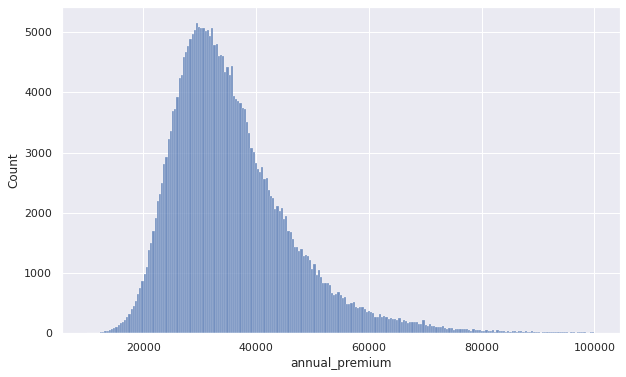

In [28]:
plt.figure(figsize(10,6))
df4 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] <100000)]
aux0 = df4.loc[df4['response'] == 0, 'annual_premium']
sns.histplot(aux0)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

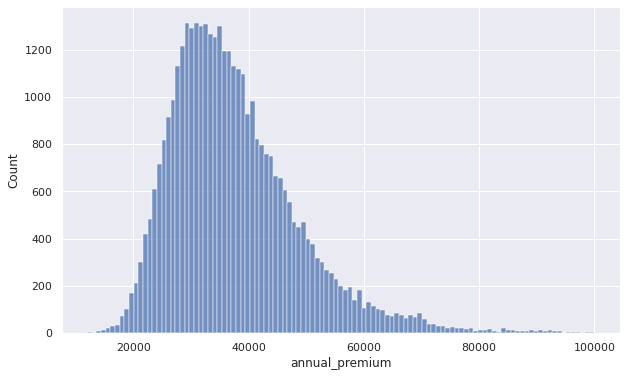

In [29]:
plt.figure(figsize(10,6))
aux0 = df4.loc[df4['response'] == 1, 'annual_premium']
sns.histplot(aux0)

### 4.1.3. Driving License

<AxesSubplot:xlabel='response', ylabel='driving_license'>

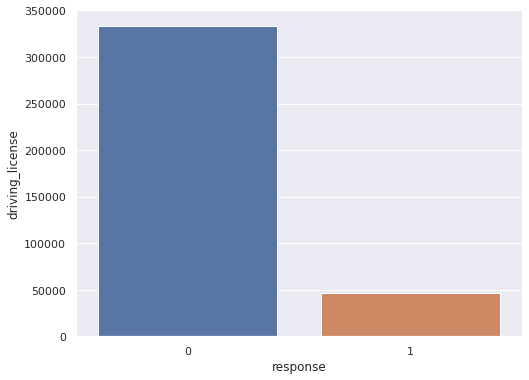

In [19]:
# driving_license
aux0 = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
plt.figure(figsize(8,6))
sns.barplot(x = 'response', y = 'driving_license', data = aux0)

### 4.1.4. Region Code

<AxesSubplot:xlabel='region_code', ylabel='id'>

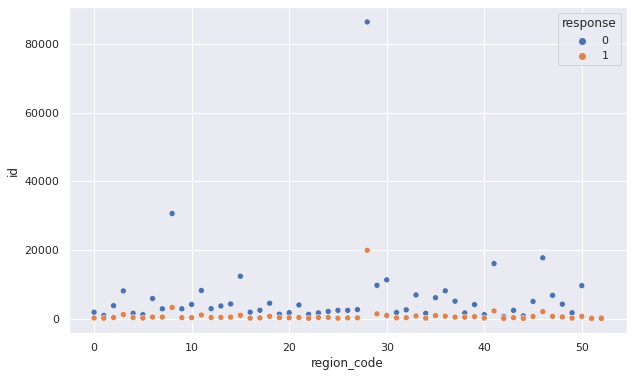

In [33]:
aux0 = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
plt.figure(figsize(10,6))
sns.scatterplot(x = 'region_code', y = 'id', hue = 'response', data = aux0)

### 4.1.5. Previously Insured

<AxesSubplot:xlabel='previously_insured', ylabel='id'>

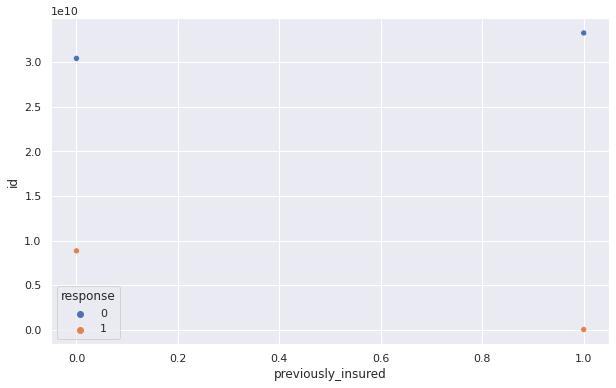

In [39]:
aux0 = df4[['id', 'previously_insured', 'response']].groupby(['previously_insured', 'response']).sum().reset_index()
plt.figure(figsize(10,6))
sns.scatterplot(x = 'previously_insured', y = 'id', hue = 'response', data = aux0)

In [20]:
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis = 1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


### 4.1.6. Vehicle Age

In [21]:
pd.crosstab(df4['vehicle_age'], df4['response']).apply(lambda x: x/x.sum(), axis = 1)

response,0,1
vehicle_age,,
1-2_year,0.826245,0.173755
<1_year,0.956295,0.043705
>2_years,0.706254,0.293746


### 4.1.7. Vehicle Damage

<AxesSubplot:xlabel='response', ylabel='vehicle_damage'>

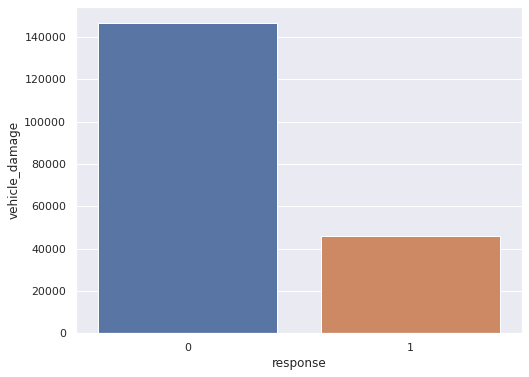

In [25]:
aux0 = df4[['vehicle_damage', 'response']].groupby('response').sum().reset_index()
plt.figure(figsize(8,6))
sns.barplot(x = 'response', y = 'vehicle_damage', data = aux0)

### 4.1.8. Policy Sales Channel 

<AxesSubplot:xlabel='response', ylabel='policy_sales_channel'>

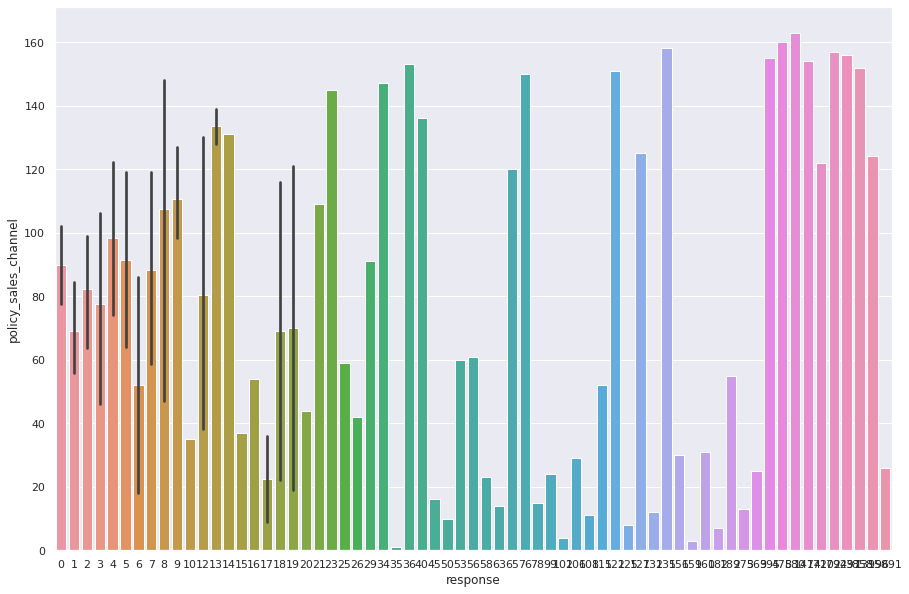

In [31]:
aux0 = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
plt.figure(figsize(15,10))
sns.barplot(x = 'response', y = 'policy_sales_channel', data = aux0)

In [48]:
aux0 = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
aux1 = df4[['policy_sales_channel', 'id']].groupby('policy_sales_channel').size().reset_index().rename(columns = {0: 'total_response'})
aux = pd.merge(aux0, aux1, how = 'inner', on = 'policy_sales_channel')

aux.head()

,policy_sales_channel,response,total_response
0,1.0,35,1074
1,2.0,1,4
2,3.0,159,523
3,4.0,102,509
4,6.0,0,3


### 4.1.9. Vintage

<AxesSubplot:xlabel='vintage', ylabel='Count'>

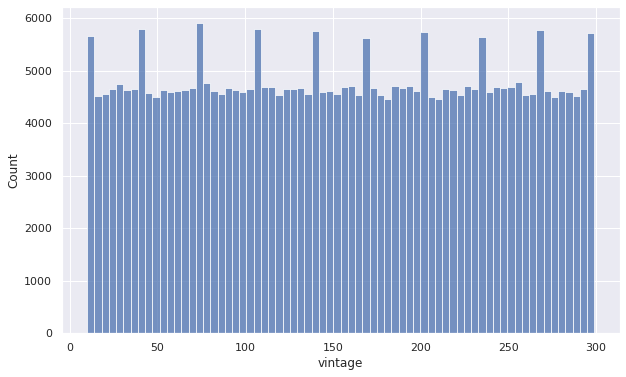

In [37]:
aux0 = df4.loc[df4['response'] == 0, "vintage" ]
plt.figure(figsize(10,6))
sns.histplot(aux0)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

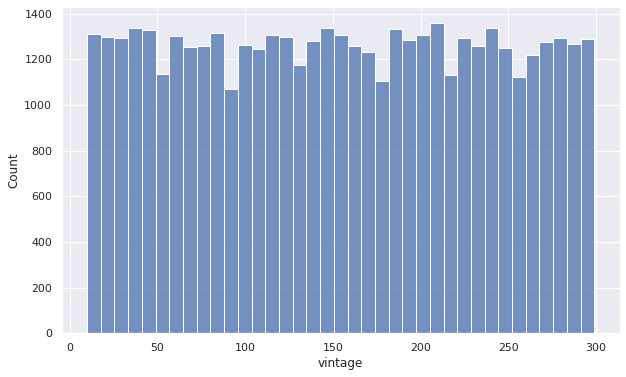

In [38]:
aux0 = df4.loc[df4['response'] == 1, 'vintage']
plt.figure(figsize(10,6))
sns.histplot(aux0)

<AxesSubplot:xlabel='vintage'>

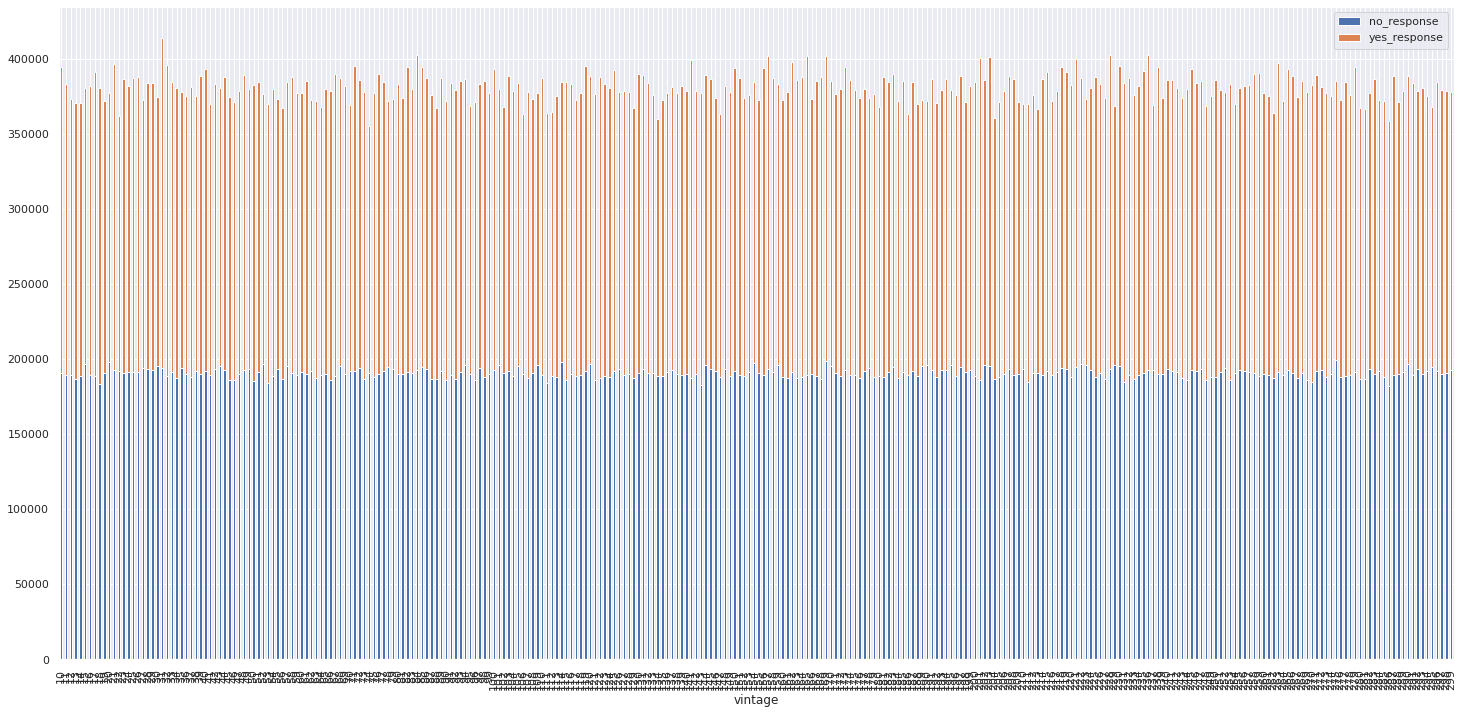

In [20]:
aux0 = pd.pivot_table(index = 'vintage', columns = 'response',values = 'id', data = df4).reset_index()
aux0.columns = ['vintage', 'no_response', 'yes_response']

#plt.figure(figsize(10,6))
aux0.plot(x = 'vintage', kind = 'bar', stacked = True)

# 5.0. Data Preparation

In [18]:
X = df4.drop('response', axis = 1)
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size = 0.3)

df5 = pd.concat([x_train, y_train], axis = 1)

## 5.1. Standardization

In [19]:
ss = pp.StandardScaler()

# annual premium - StandardScaler
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump(ss, open('../src/features/annual_premium.pkl', 'wb'))

## 5.2. Rescaling

In [20]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age - MinMaxScaler
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age,open('../src/features/age_scaler.pkl', 'wb'))

# Vintage - MinMaxScaler
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(mms_vintage, open('../src/features/vintage_scaler.pkl', 'wb'))

## 5.3. Transformation

### 5.3.1. Encoding

In [21]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)
pickle.dump(target_encode_gender, open('../src/features/target_encode_gender.pkl', 'wb'))

#region_code - Target Encoding / Frecency Encoding
target_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_region_code)
pickle.dump(target_region_code, open('../src/features/target_region_code.pkl', 'wb'))

# vehicle_age - One  Hot Encoding / Frequency Encoding
df5 = pd.get_dummies(df5, prefix = 'vehicle_age', columns = ['vehicle_age'])

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open('../src/features/fe_policy_sales_channel.pkl', 'wb'))

## 5.4. Validation Preparation

In [22]:
# gender
x_validation.loc[:, 'gender'] = x_validation.loc[: , 'gender'].map(target_encode_gender)

# age
x_validation.loc[:, 'age'] = mms_age.transform(x_validation[['age']].values)

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_region_code)

# vehicle_age
x_validation = pd.get_dummies(x_validation, prefix = 'vehicle_age', columns = ['vehicle_age'])

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation.loc[:, 'policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform(x_validation[['vintage']].values)

# fillna
x_validation = x_validation.fillna(0)

# 6.0. Feature Selection

In [25]:
x_train_n = df5.drop(['id', 'response'], axis = 1).values
y_train_n = y_train.values.ravel()

# define model
et = en.ExtraTreesClassifier(n_jobs = 1)

#define boruta
boruta = bt.BorutaPy(et, n_estimators = 'auto', verbose = 2, random_state = 42).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
I

In [26]:
boruta.support_.tolist()

[False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [27]:
#cols_selected = boruta.support_.tolist()
cols_selected = [False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

# best features
x_train_fs = df5.drop(['id', 'response'], axis = 1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

## 6.2. Feature Importance

In [28]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators = 20, random_state = 0, n_jobs = -1)

# data preparation
x_train_n = df5.drop(['id', 'response'], axis = 1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=20, n_jobs=-1, random_state=0)

Feature ranking:
                feature  importance
0               vintage    0.274801
0        annual_premium    0.243225
0                   age    0.154372
0           region_code    0.110271
0        vehicle_damage    0.078724
0  policy_sales_channel    0.061975
0    previously_insured    0.047700
0   vehicle_age_<1_year    0.013364
0  vehicle_age_1-2_year    0.006443
0                gender    0.006099
0  vehicle_age_>2_years    0.002531
0       driving_license    0.000494


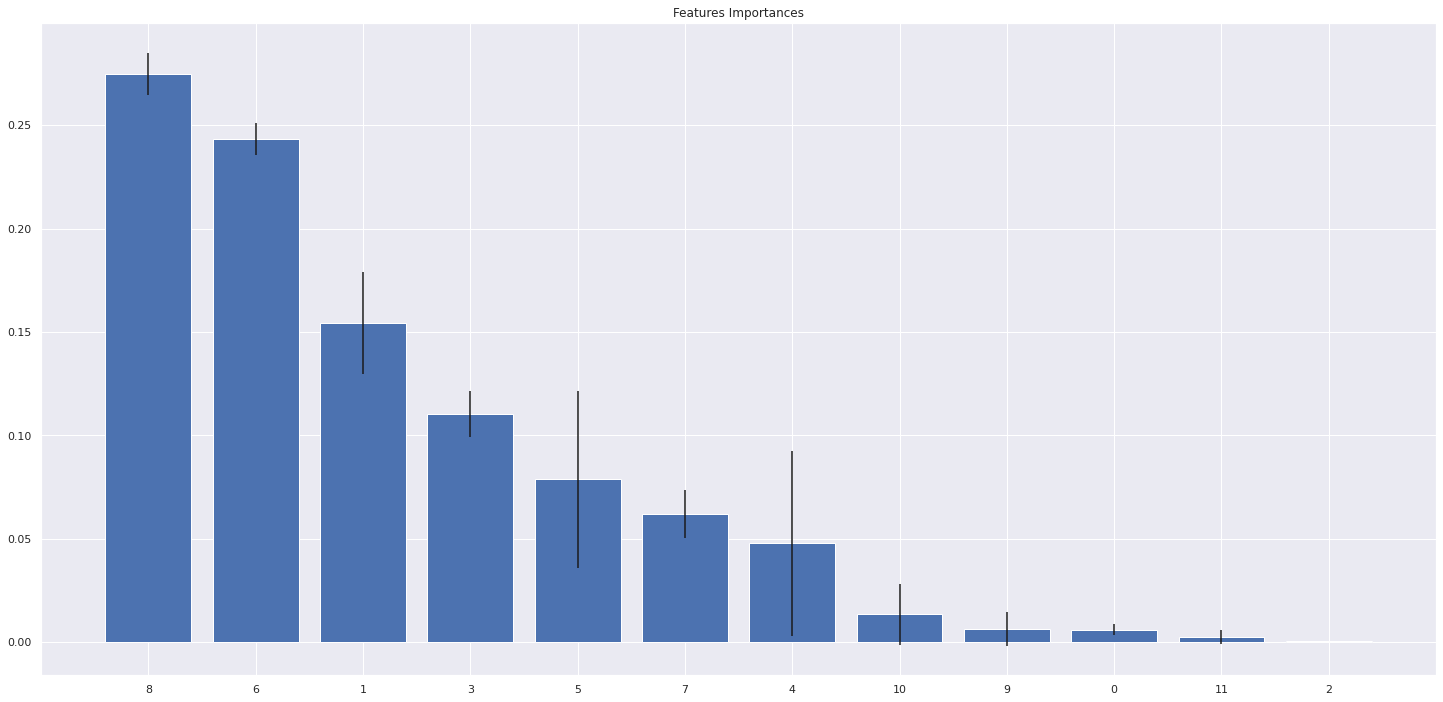

In [38]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index = [0])
    df = pd.concat([df, aux], axis = 0)
    
print(df.sort_values('importance', ascending = False))

# Plot the impurity - based feature importances of the forest
plt.figure()
plt.title("Features Importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color = 'b', yerr = std[indices], align = 'center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0. Machine Learning Modelling

In [29]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

In [30]:
x_train = df5[cols_selected]

x_val = x_validation[cols_selected]
y_val = y_validation

In [58]:
# Save datasets to  ML

# Save datasets training 
x_train.to_csv('../data/processed/x_train.csv')
y_train.to_csv('../data/processed/y_train.csv')

# Save datasets validation
x_val.to_csv('../data/processed/x_val.csv')
y_val.to_csv('../data/processed/y_val.csv')

## 7.1. KNN Classifier

In [31]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train, y_train)

# model prediction
yhat_knn = knn_model.predict_proba(x_val)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

<Figure size 720x432 with 0 Axes>

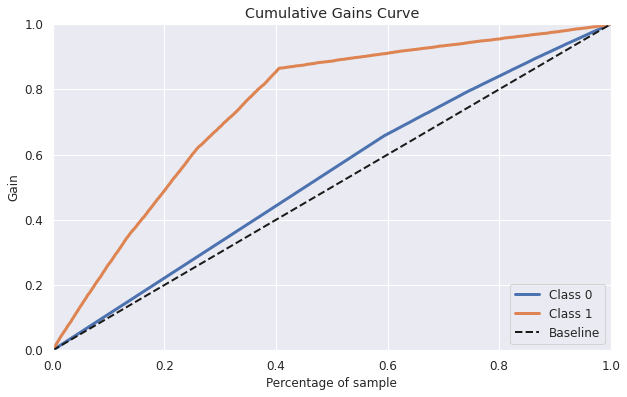

In [35]:
# Acumulative gain
plt.figure(figsize(10,6))
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn)

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

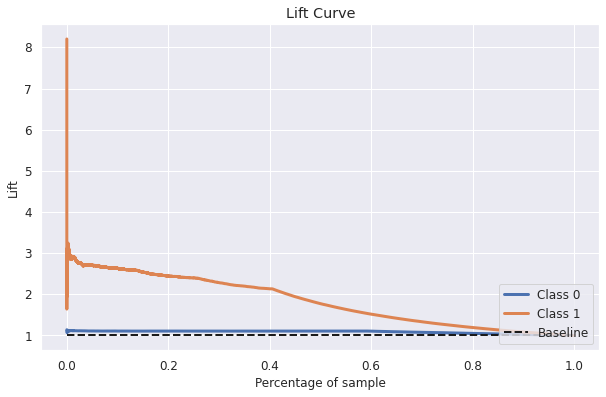

In [36]:
# Acumulative lift
skplt.metrics.plot_lift_curve(y_val, yhat_knn)

## 7.2. Logistic Regression

In [32]:
# model definition
lr_model = lm.LogisticRegression(random_state = 42)

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

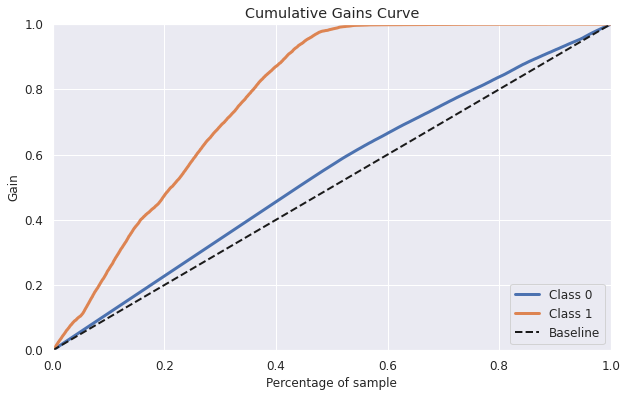

In [41]:
# Acumulative gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr)

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

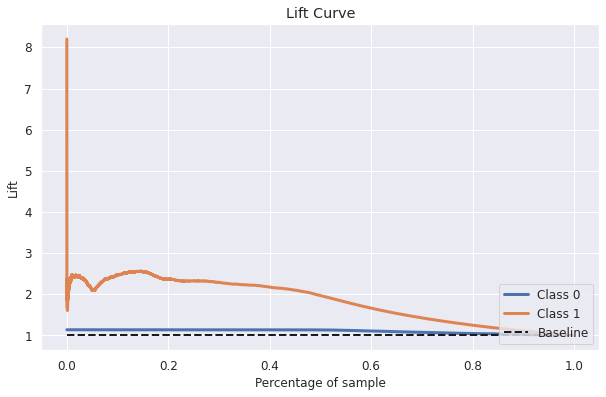

In [42]:
# Lift curve
skplt.metrics.plot_lift_curve(y_val, yhat_lr)

## 7.3. ExtraTrees Classifier

In [33]:
# model definition
et = en.ExtraTreesClassifier(n_estimators = 100, n_jobs = 1, random_state = 42)

# model training
et.fit(x_train, y_train)

# model prediction
yhat_et = et.predict_proba(x_val)

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

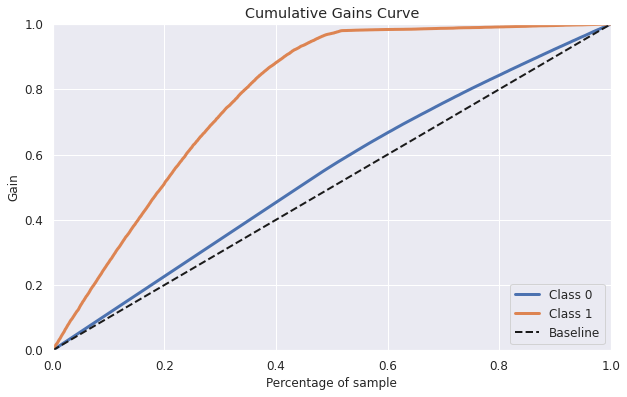

In [45]:
# Acumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_et)

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

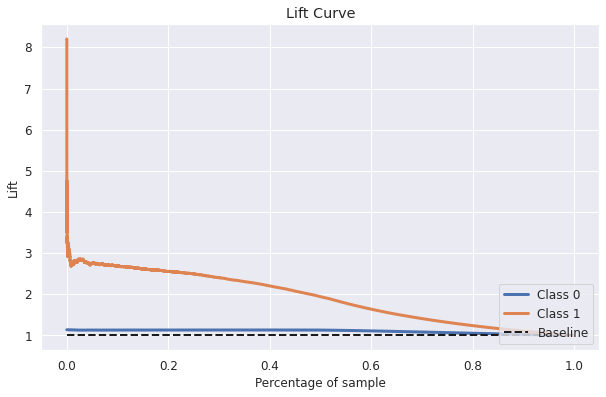

In [46]:
# Lift curve
skplt.metrics.plot_lift_curve(y_val, yhat_et)

# 8.0. Performance Metrics

In [34]:
def precision_at_k(data, k=10):
    data = data.reset_index(drop = True)
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return (data.loc[k, 'precision_at_k'], data)

In [35]:
def recall_at_k(data, k=15):
    data = data.reset_index(drop = True)
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return (data.loc[k, 'recall_at_k'], data)

In [41]:
df8.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_1-2_year,vehicle_age_<1_year,vehicle_age_>2_years,response,score
5034,5035,0.104335,0.292308,1,0.122177,0,1,-0.013865,0.209899,0.498270,1,0,0,1,1.0
233046,233047,0.104335,0.400000,1,0.125807,0,1,-1.623042,0.194260,0.391003,1,0,0,0,1.0
284197,284198,0.137843,0.538462,1,0.186680,0,1,-1.623042,0.209899,0.913495,1,0,0,0,1.0
309722,309723,0.104335,0.384615,1,0.081023,0,1,-1.623042,0.194260,0.117647,1,0,0,0,1.0
46756,46757,0.104335,0.292308,1,0.186680,0,1,-1.623042,0.209899,0.508651,1,0,0,1,1.0


In [36]:
# data copy
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

#propensity score
df8['score'] = yhat_et[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values('score', ascending=False)

# compute precision at k
precision_at_20, data = precision_at_k(df8, k = 20)

#compute recall at k
recall_at_15, data = recall_at_k(df8, k = 15)

## Cummulative Curve Manually

<AxesSubplot:xlabel='base_cum_perc', ylabel='real_cum_perc'>

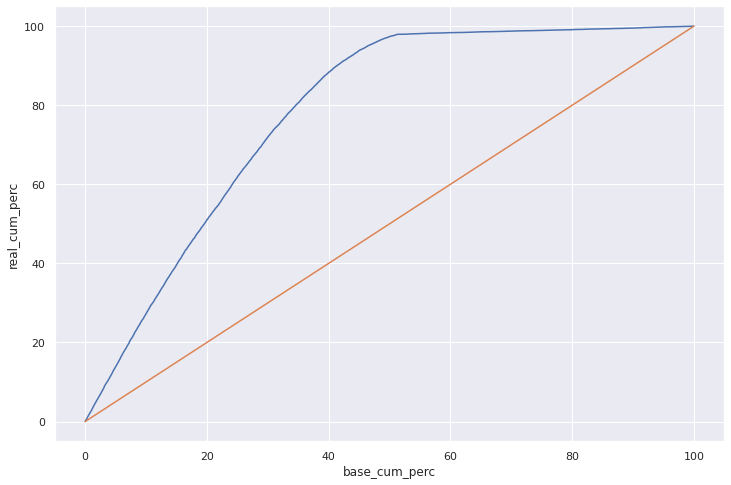

In [42]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values('prediction', ascending = False)

# Percentage of interest (Propensity Score)
results['real_cum'] = results['real'].cumsum()
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base (Clients)
results['base'] = range(1, len(results) + 1)
results['base_cum_perc'] = 100*results['base']/len(results)

# baseline model
results['baseline'] = results['base_cum_perc']

plt.figure(figsize = (12,8))
sns.lineplot(x = 'base_cum_perc', y = 'real_cum_perc', data = results)
sns.lineplot(x = 'base_cum_perc', y = 'baseline', data = results)

## Lift Curve Manually

<AxesSubplot:xlabel='base_cum_perc', ylabel='lift'>

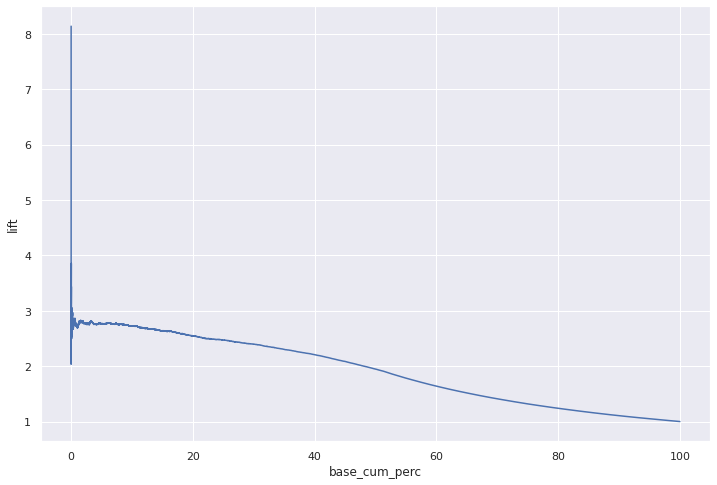

In [45]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:, 1].tolist()
results['real'] = y_val.tolist()

# Ordering by prediction
results = results.sort_values('prediction', ascending = False)

# Percentage of interest (Propensity Score)
results['real_cum'] = results['real'].cumsum()
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base (Clients)
results['base'] = range(1, len(results) + 1)
results['base_cum_perc'] = 100*results['base']/len(results)

# Baseline model
results['baseline'] = results['base_cum_perc']

# Lift calculation
results['lift'] = results['real_cum_perc']/results['base_cum_perc']

plt.figure(figsize(12,8))
sns.lineplot(x = 'base_cum_perc', y = 'lift', data = results)

## ROI Curve Manually

In [54]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:, 1].tolist()
results['real'] = y_val.tolist()

# Ordering by prediction
results = results.sort_values('prediction', ascending = False)

# Percentage of interest (Propensity Score)
results['real_cum'] = results['real'].cumsum()
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base (Clients)
results['base'] = range(1, len(results) + 1)
results['base_cum_perc'] = 100*results['base']/len(results)

# Baseline model
results['baseline'] = results['base_cum_perc']

# Lift calculation
results['lift'] = results['real_cum_perc']/results['base_cum_perc']

# ROI Curve

#plt.figure(figsize(12,8))
#sns.lineplot(x = 'base_cum_perc', y = 'lift', data = results)

In [56]:
results.head()

,prediction,real,real_cum,real_cum_perc,base,base_cum_perc,baseline,lift,bucket
57713,1.0,1,1,0.007119,1,0.000875,0.000875,8.139897,0.9
101390,1.0,0,1,0.007119,2,0.001749,0.001749,4.069949,0.9
79687,1.0,0,1,0.007119,3,0.002624,0.002624,2.713299,0.9
18188,1.0,0,1,0.007119,4,0.003499,0.003499,2.034974,0.9
111072,1.0,1,2,0.014239,5,0.004373,0.004373,3.255959,0.9


In [55]:
# Compute bucket
results['bucket'] = results['prediction'].apply(lambda x: 0.9 if x >=0.90 else
                                                          0.8 if(x >= 0.80) & (x <= 0.90) else
                                                          0.7 if(x >= 0.70) & (x <= 0.80) else
                                                          0.6 if(x >= 0.60) & (x <= 0.70) else
                                                          0.5 if(x >= 0.50) & (x <= 0.60) else
                                                          0.4 if(x >= 0.40) & (x <= 0.50) else
                                                          0.3 if(x >= 0.30) & (x <= 0.40) else
                                                          0.2 if(x >= 0.20) & (x <= 0.30) else
                                                          0.1 if(x >= 0.10) & (x <= 0.20) else 0.01)

# Aggregate clients among buckets
df = results[['prediction', 'bucket']].groupby('bucket').agg({ 'min', 'count'}).reset_index()
df.columns = df.columns.droplevel()
df.columns = ['index', 'clients', 'propensity_score']

# Compute revenue and cost
df['gross_revenue'] = 40 *df['clients'] * df['propensity_score']
df['cost'] = 4 * df['clients']

df['base'] = df['clients'].sort_values(ascending = False).cumsum() / df['clients'].sum()

# revenue
df['revenue'] = df['gross_revenue'] - df['cost']
df = df.sort_values('index', ascending = False)
df

,index,clients,propensity_score,gross_revenue,cost,base,revenue
9,0.90,219,0.9,7884.0,876,1.000000,7008.0
8,0.80,447,0.8,14304.0,1788,0.998085,12516.0
7,0.70,851,0.7,23828.0,3404,0.994175,20424.0
6,0.60,1781,0.6,42744.0,7124,0.986732,35620.0
5,0.50,3109,0.5,62180.0,12436,0.971154,49744.0
4,0.40,5020,0.4,80320.0,20080,0.943962,60240.0
3,0.30,7825,0.3,93900.0,31300,0.900055,62600.0
2,0.20,10529,0.2,84232.0,42116,0.831615,42116.0
1,0.10,12505,0.1,50020.0,50020,0.739524,0.0
0,0.01,72047,0.0,0.0,288188,0.630151,-288188.0


<AxesSubplot:xlabel='base', ylabel='revenue'>

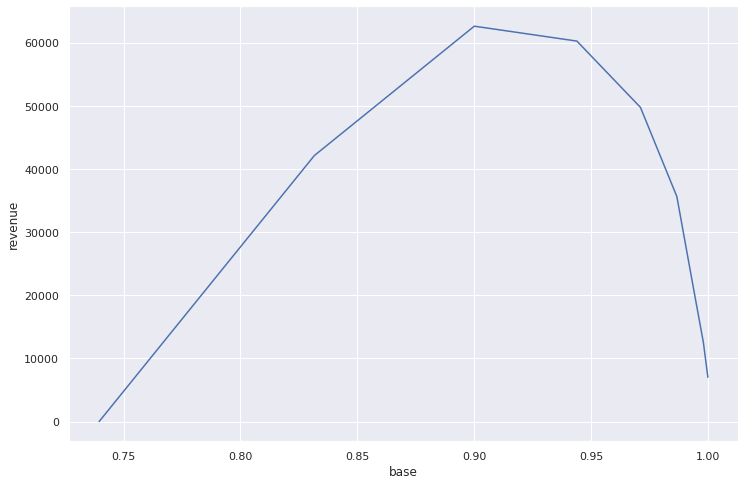

In [49]:
plt.figure(figsize(12,8))
aux = df[df['propensity_score'] >= 0.01]
sns.lineplot(x = 'base', y = 'revenue', data = aux)